In [1]:
import os
os.chdir("..")

from pprint import pprint
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from pprint import pprint

from tuxai.dataset import Dataset, Columns
from tuxai.misc import config_logger
from tuxai.report import model_metrics

config_logger()

## New method for correlated features

In [2]:
df, groups = Dataset(508).get_dataframe(
    group_collinear_options=True,
    collinearity_threshold=0.0,
    return_collinear_groups=True
)
pprint(groups)
    

2022-12-01 14:54:33,278 :: INFO :: tuxai.featureselection :: collinear options: 286 groups found, 509 columns removed


{'CORR|0000': ['EFI_STUB', 'EFI_GENERIC_STUB_INITRD_CMDLINE_LOADER'],
 'CORR|0001': ['EFI_DEV_PATH_PARSER', 'APPLE_PROPERTIES'],
 'CORR|0002': ['B44_PCI_AUTOSELECT', 'B44_PCI', 'B44_PCICORE_AUTOSELECT'],
 'CORR|0003': ['SSB_PCIHOST', 'SSB_DRIVER_PCICORE_POSSIBLE'],
 'CORR|0004': ['REGMAP',
               'SLUB',
               'CC_OPTIMIZE_FOR_SIZE',
               'HAVE_HARDENED_USERCOPY_ALLOCATOR',
               'HAVE_RELIABLE_STACKTRACE',
               'UNWINDER_ORC',
               'CC_OPTIMIZE_FOR_PERFORMANCE',
               'BITREVERSE',
               'UNWINDER_GUESS',
               'KERNEL_XZ',
               'HAVE_ALIGNED_STRUCT_PAGE',
               'SLOB',
               'KERNEL_GZIP',
               'CRC32_SLICEBY8'],
 'CORR|0005': ['QTNFMAC_PCIE', 'QTNFMAC'],
 'CORR|0006': ['AMD_MEM_ENCRYPT',
               'DMA_COHERENT_POOL',
               'ARCH_HAS_FORCE_DMA_UNENCRYPTED',
               'DYNAMIC_PHYSICAL_MASK'],
 'CORR|0007': ['WIMAX_I2400M', 'WIMAX_I2400M_USB'],
 

In [3]:
df['CORR|0006']

0        False
1        False
2        False
3         True
4        False
         ...  
21918    False
21919    False
21920     True
21921    False
21922     True
Name: CORR|0006, Length: 21923, dtype: bool

## Are correlated features important ? (for each version)

In [4]:
from tuxai.dataset import Dataset
dataset = Dataset(413)
X_train, y_train, X_test, y_test = dataset.train_test_split()

params = {
    "max_depth": 5,
    "alpha": 10,
    "learning_rate": 0.1,
    "n_estimators":100,
    "eval_metric": "mape"
}

xgb_reg = xgb.XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

2022-12-01 14:54:44,997 :: INFO :: tuxai.featureselection :: collinear options: 251 groups found, 565 columns removed


{'mean absolute error': 4.376890911698206,
 'mean squared error': 164.063452983256,
 'root mean squared error': 12.808725658052639}


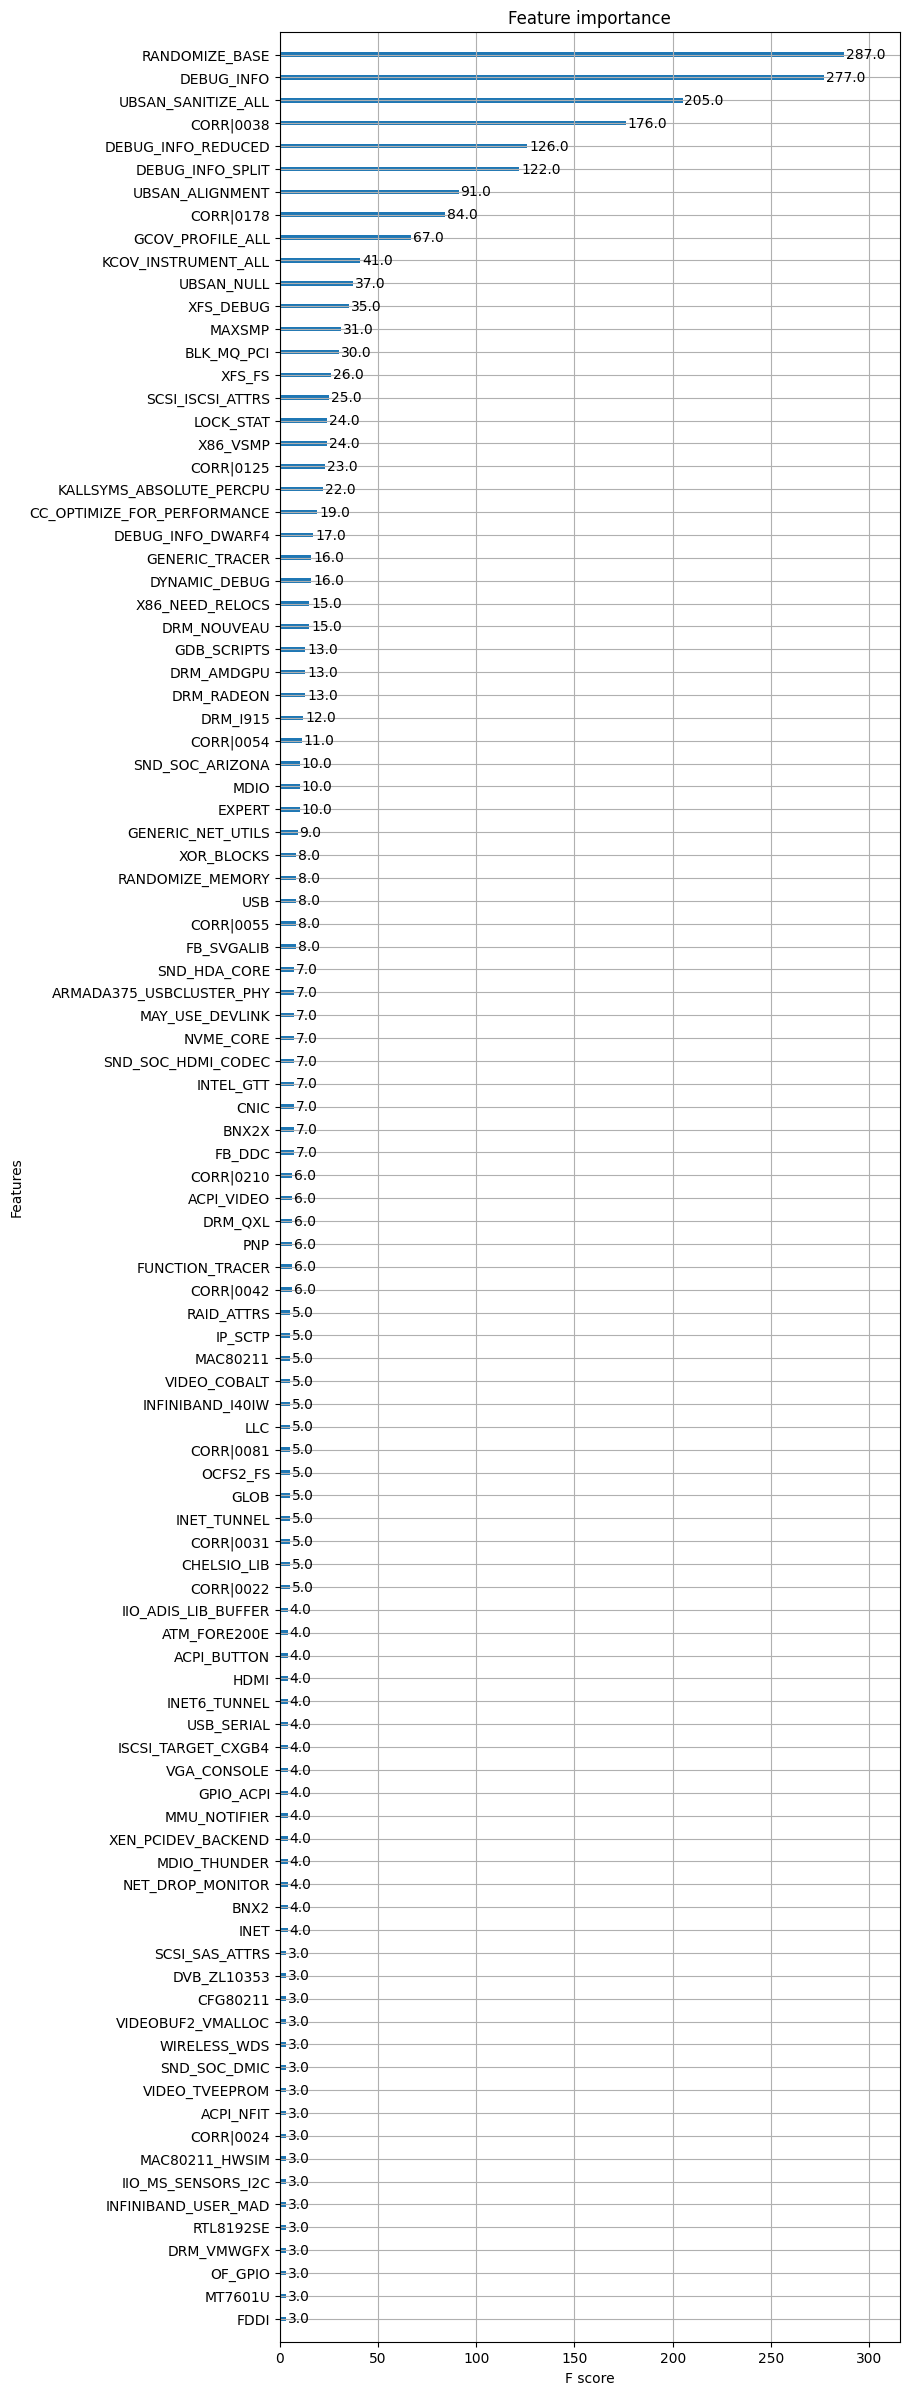

In [5]:
from tuxai.report import model_metrics
pprint(model_metrics(y_pred, y_test))
xgb.plot_importance(xgb_reg, max_num_features=100)
fig = plt.gcf()
fig.set_size_inches(8,30)

In [6]:
scores = xgb_reg.get_booster().get_score(importance_type='weight')
df_scores = pd.DataFrame.from_dict({"option": scores.keys(), "importance": scores.values()}).sort_values("importance", ascending=False)
df_scores["position"] = range(1, len(scores) + 1)
df_scores

,option,importance,position
359,RANDOMIZE_BASE,287.0,1
352,DEBUG_INFO,277.0,2
184,UBSAN_SANITIZE_ALL,205.0,3
483,CORR|0038,176.0,4
450,DEBUG_INFO_REDUCED,126.0,5
...,...,...,...
349,SENSORS_EMC6W201,1.0,758
350,INPUT_TWL4030_VIBRA,1.0,759
351,FB_I740,1.0,760
70,USB_STORAGE_JUMPSHOT,1.0,761


## Top 10 features regroupées

In [16]:
df_score_corr = df_scores[df_scores.option.str.startswith("CORR|")].copy()
df_score_corr["old"] = df_score_corr.option.apply(lambda o: ", ".join(dataset.collinear_options_[o]))
df_score_corr


,option,importance,position,old
483,CORR|0038,176.0,4,"KASAN_OUTLINE, KASAN"
442,CORR|0178,84.0,8,"MODULES, STRICT_MODULE_RWX"
293,CORR|0125,23.0,19,"PRINTK, PRINTK_NMI"
702,CORR|0054,11.0,31,"CONTEXT_SWITCH_TRACER, TRACEPOINTS, BINARY_PRI..."
90,CORR|0055,8.0,36,"SBITMAP, BLOCK, IOSCHED_NOOP"
56,CORR|0042,6.0,53,"RPS, NET_FLOW_LIMIT, RFS_ACCEL, CPU_RMAP"
567,CORR|0210,6.0,54,"LOCKDEP, DEBUG_LOCK_ALLOC"
98,CORR|0031,5.0,63,"GRACE_PERIOD, SUNRPC, LOCKD"
52,CORR|0022,5.0,66,"CLKSRC_MMIO, COMPILE_TEST, ROCKCHIP_GRF"
390,CORR|0081,5.0,67,"I2C, REGMAP_I2C"
